<a href="https://colab.research.google.com/github/kevinPoliPoli/federated-learning-project/blob/main/centralized-cifar10-resnet20-gn-v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">

## <strong>Dependencies and imports<strong/>
</div>


**Install requirements**

In [ ]:

!pip3 install 'torch'
!pip3 install 'torchvision'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

!pip3 install torchinfo


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.9/849.9 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Pillow-SIMD: filename=Pillow_SIMD-9.0.0.post1-cp310-cp310-linux_x86_64.whl size=1425305 sha256=b37e431a2668d1db10ee1b02745a35d91bd75578945e7b3b8b4e513fe2df850a
  Stored in directory: /root/.cache/pip/wheels/5b/40/80/c3580fdb22f9cc7362b26cac344b501994785f96329a3f6b94
Successfully built Pillow-SIMD


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Import libraries**

In [ ]:
import os
import logging
import numpy as np
import matplotlib.pyplot as plt 
from statistics import mean 

import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torchinfo import summary
from torch.utils.data import random_split
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR100
from torchvision.datasets import CIFAR10

from PIL import Image
from tqdm import tqdm

<div class="markdown-google-sans">

## <strong>Hyper-parameters and transformations<strong/>
</div>

**Set Arguments**

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 10    # 101: There is am extra Background class that should be removed 

BATCH_SIZE = 128     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.1                # The initial Learning Rate
MOMENTUM = 0.9          # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 0.0001   # Regularization, you can keep this at the default

NUM_EPOCHS = 160   # Total number of training epochs (iterations over dataset)

STEP_SIZE = 20      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 5

AUG_PROB = 0.5   # the probability with witch each image is transformed at training time during each epoch
AUG_TYPE = None      # define the type  of augmentation pipeline 
                     # None for no data augmentation

**Define Data Preprocessing and Augmentation**

In [ ]:
# Define transforms for training phase
train_transform = transforms.Compose([ transforms.ToTensor()   # Remember this when applying different transformations, otherwise you get an error
])

#normalizeTest = transforms.Normalize((0.5089, 0.4874, 0.4419), (0.2683, 0.2574, 0.2771))
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([ transforms.ToTensor(),   # Remember this when applying different transformations, otherwise you get an error
#normalizeTest
])

**FData augmentation**

In [ ]:
rc_t = transforms.RandomCrop(32, padding=4)
hflip_t = transforms.RandomHorizontalFlip(p = 1)
normalizer = transforms.Normalize(mean = (0.5071, 0.4867, 0.4408), std= (0.2675, 0.2565, 0.2761))

aug_transformation = transforms.Compose([hflip_t, rc_t])

aug_pipeline = transforms.Compose([   transforms.ToPILImage(),
                                      transforms.RandomApply([aug_transformation], p = AUG_PROB),
                                      transforms.ToTensor(),
                                      normalizer
                                  ])

**Prepare Dataset**

In [ ]:
from sklearn.model_selection import train_test_split

# Prepare Pytorch train/test Datasets
TRAIN_DATASET = CIFAR10(root="data", train=True, download=True, transform=train_transform)
TEST_DATASET = CIFAR10(root="data", train=False, download=True, transform=eval_transform)

train_set, val_set, _ = random_split(TRAIN_DATASET, [45000, 5000, 50000-len(TRAIN_DATASET)])

# Check dataset sizes
print('-----------------------------------------')
print('CIFAR100 TRAIN Dataset: {}'.format(len(TRAIN_DATASET)))
print('CIFAR100 TEST Dataset: {}'.format(len(TEST_DATASET)))
print('-----------------------------------------')
print('Train Dataset: {}'.format(len(train_set)))
print('Valid Dataset: {}'.format(len(val_set)))
print('Test Dataset: {}'.format(len(TEST_DATASET)))

100%|██████████| 170498071/170498071 [00:12<00:00, 13143463.39it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
-----------------------------------------
CIFAR100 TRAIN Dataset: 50000
CIFAR100 TEST Dataset: 10000
-----------------------------------------
Train Dataset: 45000
Valid Dataset: 5000
Test Dataset: 10000


**Prepare Dataloaders**

In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
val_dataloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(TEST_DATASET, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

351
40
79


<div class="markdown-google-sans">

## <strong>ResNet definition<strong/>
</div>

Res net 20

In [ ]:
def _weights_init(m):
    classname = m.__class__.__name__
    print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class ResNet20(nn.Module):
    def __init__(self, num_classes):
        super(ResNet20, self).__init__()

        self.num_classes = 100
        self.image_channels = 3
        self.in_channels = 16

        self.conv1 = nn.Conv2d(self.image_channels, 16, kernel_size=3, stride=1, padding=1, bias=False)
        #self.bn1 = nn.BatchNorm2d(16)
        self.gn1 = nn.GroupNorm(2, 16)
        self.relu = nn.ReLU()
        #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = nn.Sequential(
            #first block
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            #nn.BatchNorm2d(16),
            nn.GroupNorm(2, 16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            #nn.BatchNorm2d(16),
            nn.GroupNorm(2, 16),
            nn.ReLU(),
            
            #second block
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            #nn.BatchNorm2d(16),
            nn.GroupNorm(2, 16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            #nn.BatchNorm2d(16),
            nn.GroupNorm(2, 16),
            nn.ReLU(),

            #third block
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            #nn.BatchNorm2d(16),
            nn.GroupNorm(2, 16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            #nn.BatchNorm2d(16),
            nn.GroupNorm(2, 16),
            nn.ReLU()
            
        )
        
        self.layer2_1 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False),
            #nn.BatchNorm2d(32),
            nn.GroupNorm(2, 32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
            #nn.BatchNorm2d(32),
            nn.GroupNorm(2, 32),
        )    
        

        self.layer2_2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
            #nn.BatchNorm2d(32),
            nn.GroupNorm(2, 32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
            #nn.BatchNorm2d(32),
            nn.GroupNorm(2, 32),
            nn.ReLU(),
        )

        self.layer2_3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
            #nn.BatchNorm2d(32),
            nn.GroupNorm(2, 32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
            #nn.BatchNorm2d(32),
            nn.GroupNorm(2, 32),
            nn.ReLU(),

        )

        self.identity_2 = nn.Sequential(
                nn.Conv2d(16,32,kernel_size=1,stride=2,bias=False),
                #nn.BatchNorm2d(32),
                nn.GroupNorm(2, 32),
            )
            

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
            #nn.BatchNorm2d(64),
            nn.GroupNorm(2, 64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            #nn.BatchNorm2d(64),
            nn.GroupNorm(2, 64),
        
        )  

        self.layer3_2 = nn.Sequential(
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            #nn.BatchNorm2d(64),
            nn.GroupNorm(2, 64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            #nn.BatchNorm2d(64),
            nn.GroupNorm(2, 64),
            nn.ReLU(),
             
        )

        self.layer3_3 = nn.Sequential(
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            #nn.BatchNorm2d(64),
            nn.GroupNorm(2, 64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            #nn.BatchNorm2d(64),
            nn.GroupNorm(2, 64),
            nn.ReLU(),
             
        )

        self.identity_3 = nn.Sequential(
                nn.Conv2d(32,64,kernel_size=1,stride=2,bias=False),
                #nn.BatchNorm2d(64),
                nn.GroupNorm(2, 64),
            )



        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, self.num_classes)

        #self.apply(_weights_init)

        #self.size = self.model_size()

    def forward(self, x):
        #base
        x = self.conv1(x)
        #x = self.bn1(x)
        x = self.gn1(x)
        x = self.relu(x)
        #x = self.maxpool(x)
        
        #16
        x = self.layer1(x)

        #32
        identity = x.clone()
        x = self.layer2_1(x)
        identity = self.identity_2(identity)
        x = x.clone() + identity
        x = self.relu(x)
        x = self.layer2_2(x)
        x = self.layer2_3(x)
        
        #64
        identity = x.clone()
        x = self.layer3(x)
        identity = self.identity_3(identity)
        x = x.clone() + identity
        x = self.relu(x)
        x = self.layer3_2(x)
        x = self.layer3_3(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x
    
    """
    def model_size(self):
        tot_size = 0
        for param in self.parameters():
            tot_size += param.size()[0]
        return tot_size
    """



<div class="markdown-google-sans">

## <strong>Training<strong/>
</div>

**Prepare Training**

In [ ]:
net = ResNet20(NUM_CLASSES).cuda(); # first implementation

net_summary = summary(net, input_size=(BATCH_SIZE,3,32,32), depth=4) 
print(str(net_summary)) #show the model architecture

# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
parameters_to_optimize = net.parameters()

# Define optimizer
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
T_max = NUM_EPOCHS
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=0.00000015)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, STEP_SIZE, eta_min=0.000015)

Layer (type:depth-idx)                   Output Shape              Param #
CifarResNet                              [128, 10]                 --
├─Conv2d: 1-1                            [128, 16, 32, 32]         432
├─GroupNorm: 1-2                         [128, 16, 32, 32]         32
├─ReLU: 1-3                              [128, 16, 32, 32]         --
├─Sequential: 1-4                        [128, 16, 32, 32]         --
│    └─BasicBlock: 2-1                   [128, 16, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 16, 32, 32]         2,304
│    │    └─GroupNorm: 3-2               [128, 16, 32, 32]         32
│    │    └─ReLU: 3-3                    [128, 16, 32, 32]         --
│    │    └─Conv2d: 3-4                  [128, 16, 32, 32]         2,304
│    │    └─GroupNorm: 3-5               [128, 16, 32, 32]         32
│    │    └─ReLU: 3-6                    [128, 16, 32, 32]         --
│    └─BasicBlock: 2-2                   [128, 16, 32, 32]         --
│    │  

**Validation**

In [ ]:

def evaluate(net, dataloader, last_accuracy, update, print_tqdm = True):
  
  with torch.no_grad():
    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    net.train(False) # Set Network to evaluation mode
    running_corrects = 0
    iterable = tqdm(dataloader) if print_tqdm else dataloader
    losses = []
    for images, labels in iterable: 
      norm_images = []
      for image in images:
        norm_image = normalizer(image)
        norm_images.append(norm_image)
      norm_images = torch.stack(norm_images)  
      norm_images = norm_images.to(DEVICE)
      labels = labels.to(DEVICE)
      # Forward Pass
      outputs = net(norm_images)
      loss = criterion(outputs, labels)
      losses.append(loss.item())
      # Get predictions
      _, preds = torch.max(outputs.data, 1)
      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()
    # Calculate Accuracy
    accuracy = running_corrects / float(len(dataloader.dataset))
    if update is True:
      if accuracy > last_accuracy:
        torch.save(net.state_dict(), f"{net.__class__.__name__}-gn-cifar{NUM_CLASSES}-v1.pth")
        last_accuracy = accuracy
        print("model updated")
      else:
        print("model not updated")

  return accuracy, mean(losses), last_accuracy

In [ ]:

def evaluateTest(net, dataloader, print_tqdm = True):
  normalizeTest = transforms.Normalize((0.5089, 0.4874, 0.4419), (0.2683, 0.2574, 0.2771))
  net.load_state_dict(torch.load(f"{net.__class__.__name__}-gn-cifar{NUM_CLASSES}-v1.pth"))
  with torch.no_grad():
    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    net.train(False) # Set Network to evaluation mode
    running_corrects = 0
    iterable = tqdm(dataloader) if print_tqdm else dataloader
    losses = []
    for images, labels in iterable: 
      norm_images = []
      for image in images:
        norm_image = normalizeTest(image)
        norm_images.append(norm_image)
      norm_images = torch.stack(norm_images)  
      norm_images = norm_images.to(DEVICE)
      labels = labels.to(DEVICE)
      # Forward Pass
      outputs = net(norm_images)
      loss = criterion(outputs, labels)
      losses.append(loss.item())
      # Get predictions
      _, preds = torch.max(outputs.data, 1)
      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()
    # Calculate Accuracy
    accuracy = running_corrects / float(len(dataloader.dataset))

    

  return accuracy, mean(losses)

**Train and Validation**

In [ ]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0

val_accuracies = []
val_losses = []
train_accuracies = []
train_losses = []
last_accuracy = 0

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    
    aug_images = []

    for image in images:
      aug_image = aug_pipeline(image).to(DEVICE)
      aug_images.append(aug_image) 

    aug_images = torch.stack(aug_images)

    # Bring data over the device of choice
    aug_images = aug_images.to(DEVICE)
    

    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(aug_images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  train_acc, train_loss, _ = evaluate(net, train_dataloader, last_accuracy, update=False, print_tqdm = False)
  train_accuracies.append(train_acc)
  train_losses.append(train_loss)
  
  val_acc, val_loss, last_accuracy = evaluate(net, val_dataloader, last_accuracy, update=True, print_tqdm = False)
  val_accuracies.append(val_acc)
  val_losses.append(val_loss)

  # Step the scheduler
  scheduler.step() 


Starting epoch 1/160, LR = [0.1]
Step 0, Loss 2.430860996246338
Step 5, Loss 2.775297164916992
Step 10, Loss 2.467871904373169
Step 15, Loss 2.4280781745910645
Step 20, Loss 2.308105945587158
Step 25, Loss 2.3468215465545654
Step 30, Loss 2.3850438594818115
Step 35, Loss 2.3181779384613037
Step 40, Loss 2.3484222888946533
Step 45, Loss 2.3831734657287598
Step 50, Loss 2.2966983318328857
Step 55, Loss 2.3803553581237793
Step 60, Loss 2.27180814743042
Step 65, Loss 2.303586721420288
Step 70, Loss 2.269774913787842
Step 75, Loss 2.2617602348327637
Step 80, Loss 2.3083832263946533
Step 85, Loss 2.2816948890686035
Step 90, Loss 2.292936325073242
Step 95, Loss 2.244399309158325
Step 100, Loss 2.228353977203369
Step 105, Loss 2.256821870803833
Step 110, Loss 2.277076005935669
Step 115, Loss 2.234616756439209
Step 120, Loss 2.2583861351013184
Step 125, Loss 2.2665014266967773
Step 130, Loss 2.2140111923217773
Step 135, Loss 2.167227029800415
Step 140, Loss 2.215548276901245
Step 145, Loss 2.17

KeyboardInterrupt: ignored

Best accuracies on the validation set:  0.8112


<Axes: xlabel='epoch'>

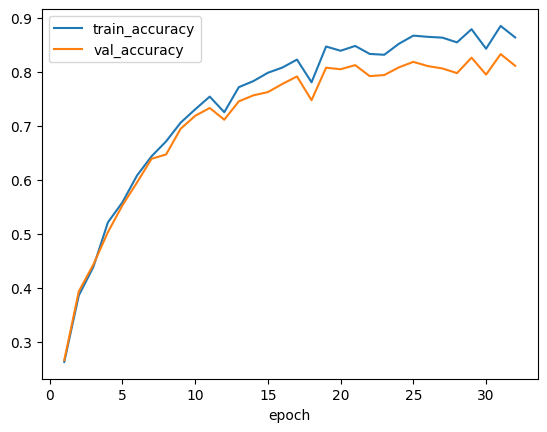

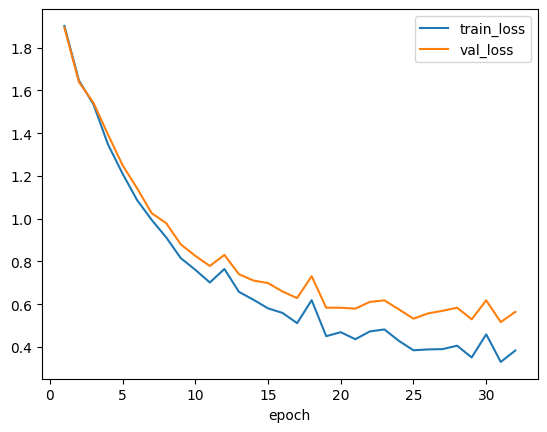

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

print("Best accuracies on the validation set: ", val_acc)

results_df = pd.DataFrame(zip(range(1,NUM_EPOCHS+1), train_accuracies, val_accuracies, train_losses, val_losses), columns = ["epoch", "train_accuracy", "val_accuracy", "train_loss", "val_loss"])
results_df.set_index("epoch")
results_df.plot(x = "epoch", y = ["train_accuracy", "val_accuracy"])
results_df.plot(x = "epoch", y = ["train_loss", "val_loss"])

**Test**

In [ ]:
state_dict = torch.load(f"{net.__class__.__name__}-gn-cifar{NUM_CLASSES}-v1.pth")
net.load_state_dict(state_dict)
accuracy = evaluateTest(net, test_dataloader)[0]
print('\nTest Accuracy: {}'.format(accuracy))

100%|██████████| 79/79 [00:07<00:00, 10.13it/s]


Test Accuracy: 0.83
